## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("../../../../h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.35.0',projectVersion='3.35.0.99999',branch='master',lastCommitHash='63c3e38305cc7c93866e89c02a380229b571fc03',gitDescribe='jenkins-master-5587-15-g63c3e38305',compiledOn='2021-10-04 14:54:53',compiledBy='potte'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 6 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024


In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OGradientBoostingEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                score_tree_interval=ntrees+1
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True,
                                      score_tree_interval=ntrees+1
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s")

    uplift_means = dict()
    rf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
    
    return uplift_means, rf_means
        
    
def plot_result(eif_means, if_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="GBM", linewidth=3, color="goldenrod")
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3, color="red")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}")
    plt.savefig(f"h2o-scale-gbm-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [5]:
max_depths = []

In [6]:
N = 100000
P = 20
max_depth = 8
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
gbm_time7, rf_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp45b6ast
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp45b6ast\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp45b6ast\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 minutes
H2O_cluster_name:,H2O_from_python_potte_2cpyce
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 24.236548900604248s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.215774536132812s
H2O session _sid_afe0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb9uv7_8t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb9uv7_8t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb9uv7_8t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 minutes
H2O_cluster_name:,H2O_from_python_potte_1159qr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 23.777491807937622s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.071000576019287s
H2O session _sid_b9e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj86fnw0l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj86fnw0l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj86fnw0l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 minutes
H2O_cluster_name:,H2O_from_python_potte_6xski7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 22.128753423690796s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.972477674484253s
H2O session _sid_8c60 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc963jlw4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc963jlw4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc963jlw4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 minutes
H2O_cluster_name:,H2O_from_python_potte_u5bdml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.232144594192505s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.886322975158691s
H2O session _sid_b1a0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9zqk_4ux
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9zqk_4ux\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9zqk_4ux\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 minutes
H2O_cluster_name:,H2O_from_python_potte_5jm49z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.42700219154358s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.449336051940918s
H2O session _sid_a80f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_oyh79cu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_oyh79cu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_oyh79cu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 minutes
H2O_cluster_name:,H2O_from_python_potte_l9wlwt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 22.098113536834717s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.119832277297974s
H2O session _sid_8cd0 closed.
Uplift 22.48334240913391s
RF 7.952457348505656s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph_hql52s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph_hql52s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph_hql52s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 minutes
H2O_cluster_name:,H2O_from_python_potte_ow57k7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.747599840164185s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.5921618938446045s
H2O session _sid_b2b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7vgm3hly
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7vgm3hly\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7vgm3hly\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 minutes
H2O_cluster_name:,H2O_from_python_potte_eyx2dd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.18376326560974s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.675574064254761s
H2O session _sid_b1db closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0xe85mwv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0xe85mwv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0xe85mwv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 minutes
H2O_cluster_name:,H2O_from_python_potte_74pxpk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.95077085494995s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.75840163230896s
H2O session _sid_9601 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3b1mpcal
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3b1mpcal\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3b1mpcal\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 minutes
H2O_cluster_name:,H2O_from_python_potte_tcq8ky
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.663176774978638s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.706779479980469s
H2O session _sid_97c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz2bat991
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz2bat991\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz2bat991\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_potte_931mx3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.157546758651733s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.211937189102173s
H2O session _sid_b055 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp43ysicgi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp43ysicgi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp43ysicgi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 minutes
H2O_cluster_name:,H2O_from_python_potte_yjny6l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.7141432762146s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.592325687408447s
H2O session _sid_97ee closed.
Uplift 20.402833461761475s
RF 7.589529991149902s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpclz6upp8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpclz6upp8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpclz6upp8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 minutes
H2O_cluster_name:,H2O_from_python_potte_qlhjg6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.694090127944946s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.60211968421936s
H2O session _sid_9aa5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9le5p3f7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9le5p3f7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9le5p3f7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 minutes
H2O_cluster_name:,H2O_from_python_potte_2qcipg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.82501220703125s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.600759744644165s
H2O session _sid_bdde closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp02nt1fpp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp02nt1fpp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp02nt1fpp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_potte_zsdqon
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.767816066741943s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.6592676639556885s
H2O session _sid_8551 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp__qt_7oq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp__qt_7oq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp__qt_7oq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_potte_1o4p30
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.666012048721313s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.476264238357544s
H2O session _sid_93e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdcfy4_wx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdcfy4_wx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdcfy4_wx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 minutes
H2O_cluster_name:,H2O_from_python_potte_82cae9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.580121994018555s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.604679822921753s
H2O session _sid_bb2d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3s7w62g2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3s7w62g2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3s7w62g2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 minutes
H2O_cluster_name:,H2O_from_python_potte_yplj9p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.79673457145691s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.653246879577637s
H2O session _sid_a186 closed.
Uplift 19.721631169319153s
RF 7.599389672279358s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2kpyqgp8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2kpyqgp8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2kpyqgp8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 minutes
H2O_cluster_name:,H2O_from_python_potte_d64p9d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.297513246536255s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.626294851303101s
H2O session _sid_9739 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmpn6ipn4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmpn6ipn4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmpn6ipn4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 minutes
H2O_cluster_name:,H2O_from_python_potte_018k27
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.307376623153687s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.607386112213135s
H2O session _sid_917f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp72h27bmn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp72h27bmn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp72h27bmn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 minutes
H2O_cluster_name:,H2O_from_python_potte_2k4rub
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.394826650619507s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.7526609897613525s
H2O session _sid_8dee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqcbq0e50
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqcbq0e50\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqcbq0e50\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 minutes
H2O_cluster_name:,H2O_from_python_potte_oezowq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.428611755371094s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.777873992919922s
H2O session _sid_a257 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnzwvs6ne
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnzwvs6ne\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnzwvs6ne\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 minutes
H2O_cluster_name:,H2O_from_python_potte_m4rha0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.011457443237305s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.860210418701172s
H2O session _sid_8da5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp8gzwc4m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp8gzwc4m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp8gzwc4m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,24 minutes
H2O_cluster_name:,H2O_from_python_potte_8ozsca
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.458569049835205s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.603380918502808s
H2O session _sid_9f66 closed.
Uplift 19.816392461458843s
RF 7.7046345472335815s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzaftohnl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzaftohnl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzaftohnl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_potte_zmngah
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.72800087928772s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.850498914718628s
H2O session _sid_a22b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn2uvumm2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn2uvumm2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn2uvumm2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,26 minutes
H2O_cluster_name:,H2O_from_python_potte_r2v1wq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.648186206817627s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.718963623046875s
H2O session _sid_96cc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_dwf0ccc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_dwf0ccc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_dwf0ccc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,27 minutes
H2O_cluster_name:,H2O_from_python_potte_7l6mcp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.099692344665527s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.81460189819336s
H2O session _sid_858f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppcn9m09o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppcn9m09o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppcn9m09o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,28 minutes
H2O_cluster_name:,H2O_from_python_potte_fm2hzp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.02867341041565s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.339188575744629s
H2O session _sid_9854 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpme34cjpj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpme34cjpj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpme34cjpj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,29 minutes
H2O_cluster_name:,H2O_from_python_potte_ly5mxs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.92559003829956s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.7676362991333s
H2O session _sid_a222 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt979n_su
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt979n_su\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt979n_su\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,30 minutes
H2O_cluster_name:,H2O_from_python_potte_5qzdhe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.767742156982422s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.822041511535645s
H2O session _sid_afa6 closed.
Uplift 20.86631417274475s
RF 8.885488470395407s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgtwlvwq1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgtwlvwq1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgtwlvwq1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,31 minutes
H2O_cluster_name:,H2O_from_python_potte_bsgcoj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.70780897140503s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.815058946609497s
H2O session _sid_b037 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgwn_4wzn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgwn_4wzn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgwn_4wzn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,32 minutes
H2O_cluster_name:,H2O_from_python_potte_royy9u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.641695737838745s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.762491464614868s
H2O session _sid_9b7b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaw4tfnbz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaw4tfnbz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaw4tfnbz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,33 minutes
H2O_cluster_name:,H2O_from_python_potte_buw2ie
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.647882223129272s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.918569564819336s
H2O session _sid_99e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphznkalq3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphznkalq3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphznkalq3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,34 minutes
H2O_cluster_name:,H2O_from_python_potte_mm0kg7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.725496292114258s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.769866228103638s
H2O session _sid_8665 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsu8o_cme
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsu8o_cme\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsu8o_cme\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,35 minutes
H2O_cluster_name:,H2O_from_python_potte_wk73yw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.978528022766113s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.143506050109863s
H2O session _sid_bd9f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi6njs7uz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi6njs7uz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi6njs7uz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,36 minutes
H2O_cluster_name:,H2O_from_python_potte_yl8rg4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.731921434402466s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.850249767303467s
H2O session _sid_ba88 closed.
Uplift 27.738888780275982s
RF 14.876623670260111s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3j3fras5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3j3fras5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3j3fras5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,37 minutes
H2O_cluster_name:,H2O_from_python_potte_2cmek8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.53172421455383s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.97095012664795s
H2O session _sid_bced closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuatdhsi7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuatdhsi7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuatdhsi7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,39 minutes
H2O_cluster_name:,H2O_from_python_potte_932cv4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.41932559013367s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.012860774993896s
H2O session _sid_9aa1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps5fwx5l8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps5fwx5l8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps5fwx5l8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,40 minutes
H2O_cluster_name:,H2O_from_python_potte_84yzrw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.34830594062805s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.885213375091553s
H2O session _sid_81ca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptk9nrhlu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptk9nrhlu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptk9nrhlu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,42 minutes
H2O_cluster_name:,H2O_from_python_potte_ni0ltq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.36893820762634s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.02823233604431s
H2O session _sid_a56b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbtkpui6b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbtkpui6b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbtkpui6b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_ny9kdw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.1724808216095s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.972535133361816s
H2O session _sid_9f10 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyp673b57
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyp673b57\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyp673b57\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,45 minutes
H2O_cluster_name:,H2O_from_python_potte_7qbecv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.481812953948975s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.01826810836792s
H2O session _sid_9fea closed.
Uplift 43.553764621416725s
RF 26.981343309084576s
12 - Uplift = 22.48334240913391, RF = 7.952457348505656
10 - Uplift = 20.402833461761475, RF = 7.589529991149902
8 - Uplift = 19.721631169319153, RF = 7.599389672279358
6 - Uplift = 19.816392461458843, RF = 7.7046345472335815
4 - Uplift = 20.86631417274475, RF = 8.885488470395407
2 - Uplift = 27.738888780275982, RF = 14.876623670260111
1 - Uplift = 43.553764621416725, RF = 26.981343309084576


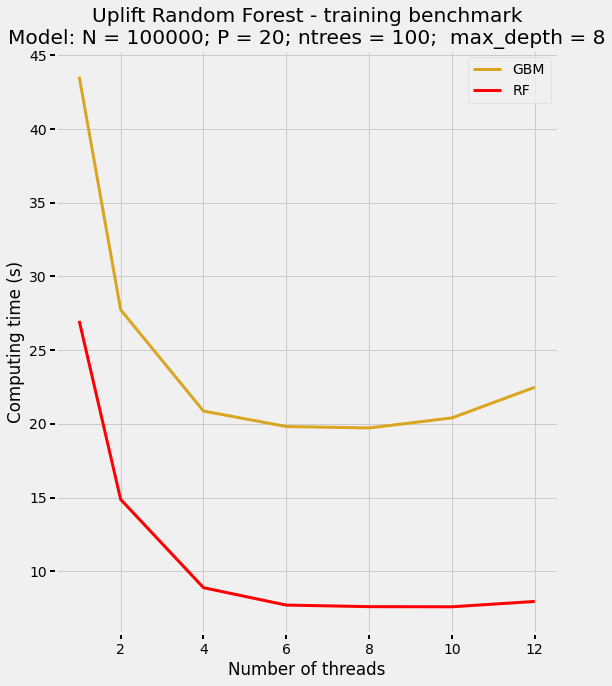

In [8]:
plot_result(gbm_time7, rf_time7)

In [9]:
N = 100000
P = 20
max_depth = 16
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
gbm_time8, rf_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpim4_p3or
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpim4_p3or\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpim4_p3or\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,47 minutes
H2O_cluster_name:,H2O_from_python_potte_au18ep
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 173.92389011383057s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.41148328781128s
H2O session _sid_bd91 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdcp1l6jz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdcp1l6jz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdcp1l6jz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_s45i3r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 174.69467329978943s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.00162386894226s
H2O session _sid_8994 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu6so_2_5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu6so_2_5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu6so_2_5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_86nfv6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 175.6699206829071s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.25904560089111s
H2O session _sid_ab68 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpil6z11g9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpil6z11g9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpil6z11g9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour
H2O_cluster_name:,H2O_from_python_potte_7x5ftf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 173.3492350578308s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.80124235153198s
H2O session _sid_aebc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvwnjaec3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvwnjaec3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvwnjaec3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_vr6knh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 175.715514421463s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.04154992103577s
H2O session _sid_bde0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpak65c9qm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpak65c9qm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpak65c9qm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_ovrdgf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 172.92766165733337s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.747780084609985s
H2O session _sid_b647 closed.
Uplift 174.38014920552573s
RF 63.210454185803734s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2p_431yi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2p_431yi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2p_431yi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_xt05mx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 157.42653393745422s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.9487521648407s
H2O session _sid_9ef2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3ffwfpld
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3ffwfpld\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3ffwfpld\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_uew4k2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 158.55661344528198s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.18988060951233s
H2O session _sid_bd95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp86me9z0s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp86me9z0s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp86me9z0s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_g6hpq6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 160.92170882225037s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.59417533874512s
H2O session _sid_ad66 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9je969n2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9je969n2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9je969n2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_8ezalq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 159.82880687713623s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.638214111328125s
H2O session _sid_9481 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdq9exp6y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdq9exp6y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdq9exp6y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_1gks82
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 162.12591361999512s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.71391010284424s
H2O session _sid_baef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgn8_jt_q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgn8_jt_q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgn8_jt_q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_q4uj2t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 159.6336727142334s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.76910352706909s
H2O session _sid_be5d closed.
Uplift 159.74887490272522s
RF 58.30900597572327s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjhs193rq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjhs193rq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjhs193rq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_f9yrui
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 145.73220443725586s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.35752487182617s
H2O session _sid_9ac9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprg8541jk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprg8541jk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprg8541jk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_t7snt4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 147.28930473327637s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.45992183685303s
H2O session _sid_8db4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkqzi7v4i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkqzi7v4i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkqzi7v4i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_07dwyj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 147.54233479499817s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.004337549209595s
H2O session _sid_8f01 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppya2ph39
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppya2ph39\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppya2ph39\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_1vugny
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 147.3341987133026s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.11592388153076s
H2O session _sid_b471 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzpg445a2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzpg445a2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzpg445a2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_5uutda
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 148.41782069206238s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.732014179229736s
H2O session _sid_b34c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppgmso0bu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppgmso0bu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppgmso0bu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_eps2u0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 146.62097001075745s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.17001295089722s
H2O session _sid_9611 closed.
Uplift 147.15613889694214s
RF 54.306622544924416s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpncpu_m_c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpncpu_m_c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpncpu_m_c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours
H2O_cluster_name:,H2O_from_python_potte_x3nnxw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 135.746098279953s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.59327149391174s
H2O session _sid_9103 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphzxecln_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphzxecln_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphzxecln_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_upq7z4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 136.4915473461151s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.86131763458252s
H2O session _sid_a9d5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpajdsh1f2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpajdsh1f2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpajdsh1f2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_uu0kib
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 136.70607781410217s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.015718936920166s
H2O session _sid_a27c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph4hxlubp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph4hxlubp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph4hxlubp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_udsylz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 136.8232262134552s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.775192975997925s
H2O session _sid_9cf4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdbdjihdn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdbdjihdn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdbdjihdn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_bvo0ii
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.01514220237732s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.59826159477234s
H2O session _sid_b0f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp489thijj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp489thijj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp489thijj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_0h9od1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.29949283599854s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.593605041503906s
H2O session _sid_960c closed.
Uplift 136.68026411533356s
RF 51.23956127961477s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb1tqjwsq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb1tqjwsq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb1tqjwsq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_xy1gr0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 128.50510668754578s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.936397075653076s
H2O session _sid_935f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp0zpb22v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp0zpb22v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp0zpb22v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_mksf4z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 127.92269825935364s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.206862926483154s
H2O session _sid_9514 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8eq6_kvm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8eq6_kvm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8eq6_kvm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_71jq7p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 126.99913787841797s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.97518038749695s
H2O session _sid_b8df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_jqsuyyr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_jqsuyyr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_jqsuyyr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_sgsz7i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 127.71431946754456s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.04451537132263s
H2O session _sid_b608 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwekl_kj3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwekl_kj3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwekl_kj3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_k5c0ud
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 128.73848819732666s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.742295265197754s
H2O session _sid_8adc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi_hmfb9d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi_hmfb9d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi_hmfb9d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_fhntfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 128.170095205307s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.869521141052246s
H2O session _sid_a003 closed.
Uplift 128.00830761591592s
RF 53.46246202786764s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgu9vhjjc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgu9vhjjc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgu9vhjjc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_j5419g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 152.2868468761444s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.73473048210144s
H2O session _sid_b3b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwd3qp8wd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwd3qp8wd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwd3qp8wd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_mfemdh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 152.18608713150024s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.611008644104s
H2O session _sid_ae91 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqwbm__eb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqwbm__eb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqwbm__eb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_ofr3pn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 152.73013997077942s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.83569884300232s
H2O session _sid_938f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp93ja8h1q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp93ja8h1q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp93ja8h1q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_9tkhkt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 152.66053891181946s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.85178351402283s
H2O session _sid_a297 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt6uub2ws
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt6uub2ws\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt6uub2ws\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_bzf3qn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 152.3700773715973s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 79.3416702747345s
H2O session _sid_9e76 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmhu87wwm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmhu87wwm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmhu87wwm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_jcr3it
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 156.22477293014526s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.09269881248474s
H2O session _sid_9789 closed.
Uplift 153.07641053199768s
RF 78.41126509507497s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3d78axs0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3d78axs0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3d78axs0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_1pys3r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 231.49192833900452s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.58198261260986s
H2O session _sid_b9b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4a0g5ktq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4a0g5ktq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4a0g5ktq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_rv8miw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 232.4615833759308s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.63247275352478s
H2O session _sid_a52d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6gz4g_k1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6gz4g_k1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6gz4g_k1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_z11axi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 231.94451451301575s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.65417408943176s
H2O session _sid_a3d5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9gvx2k9c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9gvx2k9c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9gvx2k9c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_vktxcm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 232.53057050704956s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.8267059326172s
H2O session _sid_8d46 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplsjs6seu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplsjs6seu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplsjs6seu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_zlpxhp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 223.73635387420654s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.4774935245514s
H2O session _sid_961e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptmfm6v_k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptmfm6v_k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptmfm6v_k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_taxaya
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 230.55001735687256s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.6418912410736s
H2O session _sid_9712 closed.
Uplift 230.45249466101328s
RF 146.63578669230142s
12 - Uplift = 174.38014920552573, RF = 63.210454185803734
10 - Uplift = 159.74887490272522, RF = 58.30900597572327
8 - Uplift = 147.15613889694214, RF = 54.306622544924416
6 - Uplift = 136.68026411533356, RF = 51.23956127961477
4 - Uplift = 128.00830761591592, RF = 53.46246202786764
2 - Uplift = 153.07641053199768, RF = 78.41126509507497
1 - Uplift = 230.45249466101328, RF = 146.63578669230142


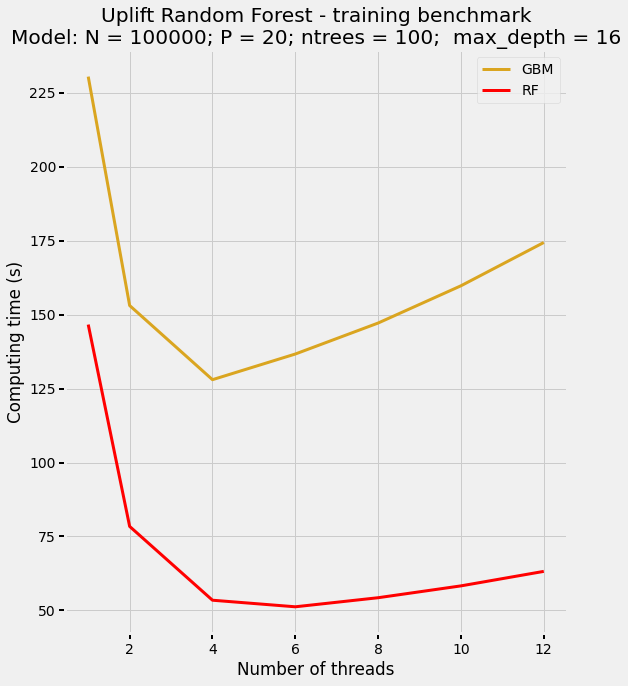

In [11]:
plot_result(gbm_time8, rf_time8)

### Bigger sample_size

In [12]:
N = 100000
P = 20
max_depth = 20
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
gbm_time9, rf_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0j_248i3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0j_248i3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0j_248i3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_w3csu0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 306.3768014907837s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.02739453315735s
H2O session _sid_bad5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnln8kty2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnln8kty2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnln8kty2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_ywngfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 311.4845862388611s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.95531177520752s
H2O session _sid_9126 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxs_z5zp3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxs_z5zp3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxs_z5zp3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_vrjt6k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 310.0420446395874s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.20268392562866s
H2O session _sid_9407 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnyvvvz72
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnyvvvz72\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnyvvvz72\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_ja9yyp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 309.7283318042755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.52120852470398s
H2O session _sid_b090 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp85opntty
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp85opntty\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp85opntty\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_9sf6dn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 312.60860681533813s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.26598501205444s
H2O session _sid_899e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3j28lzuy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3j28lzuy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3j28lzuy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_twmtpl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 308.5391094684601s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.98383283615112s
H2O session _sid_82ee closed.
Uplift 309.79658007621765s
RF 75.49273610115051s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvqp8h24n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvqp8h24n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvqp8h24n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_90y3k9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.2454459667206s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.7543535232544s
H2O session _sid_aa85 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp88o2jo4m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp88o2jo4m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp88o2jo4m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_fzz2xp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.25464510917664s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.08920955657959s
H2O session _sid_91da closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ar8hvyq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ar8hvyq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1ar8hvyq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_qzdin3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.57854318618774s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.49381971359253s
H2O session _sid_b755 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb_co5cs_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb_co5cs_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb_co5cs_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_uuxz1u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.68493819236755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.18327689170837s
H2O session _sid_924d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa0khc9w_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa0khc9w_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa0khc9w_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_r1bsoq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.8534858226776s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.24254751205444s
H2O session _sid_935c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfrb1806o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfrb1806o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfrb1806o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_fzxo7t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.9510746002197s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.4265525341034s
H2O session _sid_9af6 closed.
Uplift 282.2613554795583s
RF 70.69829328854878s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0kt1r1du
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0kt1r1du\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0kt1r1du\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_kcm4p6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 259.89276909828186s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.5751576423645s
H2O session _sid_b9b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9l_7kmqn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9l_7kmqn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9l_7kmqn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_s4vnba
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.2610836029053s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.23620009422302s
H2O session _sid_8af1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppumigjky
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppumigjky\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppumigjky\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_t0wsct
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 261.3326241970062s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.25401306152344s
H2O session _sid_a365 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi8jdy0dq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi8jdy0dq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi8jdy0dq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_ganbjt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 261.2382309436798s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.42746901512146s
H2O session _sid_9874 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphd5y1mqw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphd5y1mqw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphd5y1mqw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_kg7bqm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 261.50279450416565s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.29605484008789s
H2O session _sid_9918 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe_h_uakm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe_h_uakm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe_h_uakm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_ec90sq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 258.7722749710083s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.67857503890991s
H2O session _sid_9334 closed.
Uplift 260.8332962195079s
RF 66.41124494870503s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjwhbdocq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjwhbdocq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjwhbdocq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_hxdqx7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 244.02668738365173s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.00226354598999s
H2O session _sid_907a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnojvdyax
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnojvdyax\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnojvdyax\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_opcn83
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 240.29303812980652s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.22800374031067s
H2O session _sid_8990 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzajp8np2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzajp8np2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzajp8np2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_bmi4wx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 242.80069994926453s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.14362382888794s
H2O session _sid_a0c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl0qcvqx8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl0qcvqx8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl0qcvqx8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_i6810f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 241.9961757659912s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.095327854156494s
H2O session _sid_a828 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3ues22eb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3ues22eb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3ues22eb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_syhz0t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 242.48576068878174s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.161181688308716s
H2O session _sid_be52 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_99my01x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_99my01x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_99my01x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_7lqgh8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 240.99483489990234s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.640969038009644s
H2O session _sid_b2d3 closed.
Uplift 242.0995328028997s
RF 62.54522828261057s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpok5jujd8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpok5jujd8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpok5jujd8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_5j0fhr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 222.87775778770447s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.85944080352783s
H2O session _sid_95e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp975fdnvq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp975fdnvq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp975fdnvq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_j3i81i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 224.99365139007568s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.20105695724487s
H2O session _sid_892d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpex3udny9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpex3udny9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpex3udny9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_pp0i7j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 224.10157132148743s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.24056148529053s
H2O session _sid_bede closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp38rgmh4g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp38rgmh4g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp38rgmh4g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_2rz16a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 223.1128852367401s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.48340082168579s
H2O session _sid_a6b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphebz8fnm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphebz8fnm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphebz8fnm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_yf5id0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 222.62148690223694s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.32048010826111s
H2O session _sid_b4c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsee0i2x0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsee0i2x0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsee0i2x0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_x2x954
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 220.9606385231018s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.6345489025116s
H2O session _sid_b4c2 closed.
Uplift 223.1113318602244s
RF 65.12324817975362s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptu7adwbg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptu7adwbg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptu7adwbg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_qg23o6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 260.49267768859863s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.53611826896667s
H2O session _sid_9987 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpucurqja8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpucurqja8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpucurqja8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_g8p0fu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 254.78728556632996s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.71148180961609s
H2O session _sid_82fe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph1o4mp_n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph1o4mp_n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph1o4mp_n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_8tkf8z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 257.22130727767944s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.8226866722107s
H2O session _sid_9513 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0zfu6alh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0zfu6alh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0zfu6alh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_frrtuy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 260.91511511802673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.96230292320251s
H2O session _sid_b045 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo5gx5rip
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo5gx5rip\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo5gx5rip\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_zt6i3r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 259.933082818985s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.14419317245483s
H2O session _sid_a84a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp218nhzgu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp218nhzgu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp218nhzgu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_ywr95l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 259.14139008522034s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.54550051689148s
H2O session _sid_9a73 closed.
Uplift 258.7484764258067s
RF 94.78704722722371s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnzvdhnkl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnzvdhnkl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnzvdhnkl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_k4kblq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 387.4986116886139s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.43408203125s
H2O session _sid_b219 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfg4ryumy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfg4ryumy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfg4ryumy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_wqrece
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 387.5656063556671s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 178.03193855285645s
H2O session _sid_970b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfr6rz2qi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfr6rz2qi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfr6rz2qi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_oceg3g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 390.4493000507355s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 179.1856198310852s
H2O session _sid_8a48 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg1ijnjcv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg1ijnjcv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg1ijnjcv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_3s91w0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 388.5066075325012s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 180.48925614356995s
H2O session _sid_a4eb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprucooyqv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprucooyqv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprucooyqv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_fsrcxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 374.23068380355835s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 174.7657663822174s
H2O session _sid_aff5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0vqhl4e6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0vqhl4e6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0vqhl4e6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_rj0soi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 389.65220522880554s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 179.2867558002472s
H2O session _sid_945c closed.
Uplift 386.3171691099803s
RF 178.1989031235377s
12 - Uplift = 309.79658007621765, RF = 75.49273610115051
10 - Uplift = 282.2613554795583, RF = 70.69829328854878
8 - Uplift = 260.8332962195079, RF = 66.41124494870503
6 - Uplift = 242.0995328028997, RF = 62.54522828261057
4 - Uplift = 223.1113318602244, RF = 65.12324817975362
2 - Uplift = 258.7484764258067, RF = 94.78704722722371
1 - Uplift = 386.3171691099803, RF = 178.1989031235377


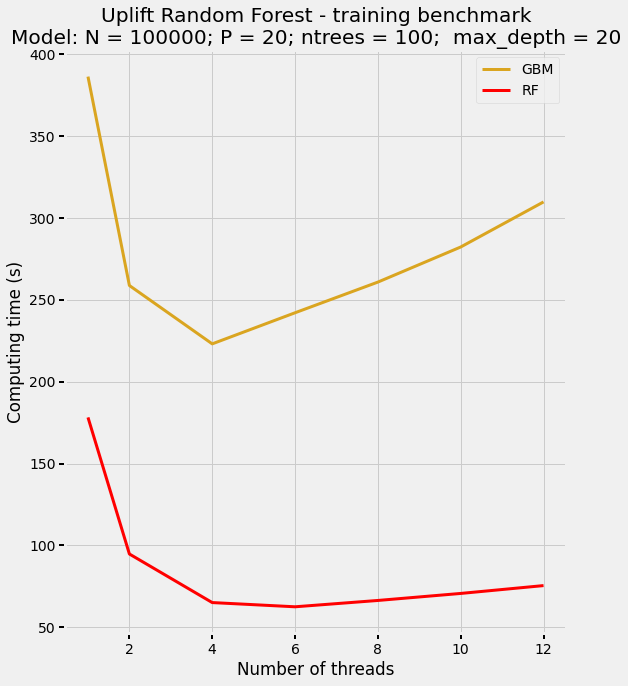

In [14]:
plot_result(gbm_time9, rf_time9)

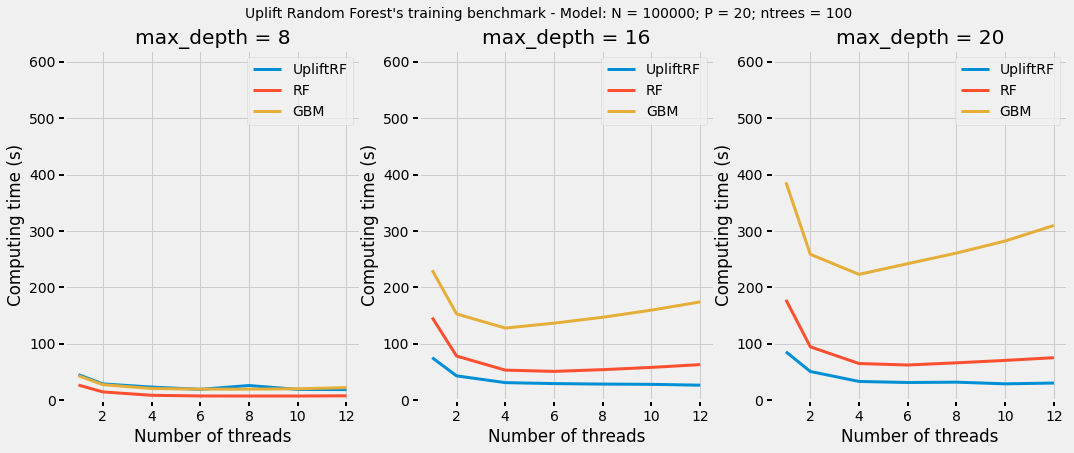

In [15]:
all_predict_uplift = [{12: 18.93900990486145, 10: 19.30182449022929, 8: 26.17604915301005, 6: 19.397459427515667, 4: 23.40986116727193, 2: 29.07012955347697, 1: 45.50412805875143}, {12: 26.778035481770832, 10: 28.275341510772705, 8: 28.730897188186646, 6: 29.619952996571858, 4: 31.316644271214802, 2: 43.301218112309776, 1: 75.48034636179607}, {12: 30.582640409469604, 10: 29.177462100982666, 8: 32.13025641441345, 6: 31.55892292658488, 4: 33.371968825658165, 2: 51.07243879636129, 1: 85.96301698684692}]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 620)
    plt.legend() 
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 18.93900990486145, 10: 19.30182449022929, 8: 26.17604915301005, 6: 19.397459427515667, 4: 23.40986116727193, 2: 29.07012955347697, 1: 45.50412805875143}, {12: 26.778035481770832, 10: 28.275341510772705, 8: 28.730897188186646, 6: 29.619952996571858, 4: 31.316644271214802, 2: 43.301218112309776, 1: 75.48034636179607}, {12: 30.582640409469604, 10: 29.177462100982666, 8: 32.13025641441345, 6: 31.55892292658488, 4: 33.371968825658165, 2: 51.07243879636129, 1: 85.96301698684692}]


In [17]:
print(all_predict_gbm)

[{12: 22.48334240913391, 10: 20.402833461761475, 8: 19.721631169319153, 6: 19.816392461458843, 4: 20.86631417274475, 2: 27.738888780275982, 1: 43.553764621416725}, {12: 174.38014920552573, 10: 159.74887490272522, 8: 147.15613889694214, 6: 136.68026411533356, 4: 128.00830761591592, 2: 153.07641053199768, 1: 230.45249466101328}, {12: 309.79658007621765, 10: 282.2613554795583, 8: 260.8332962195079, 6: 242.0995328028997, 4: 223.1113318602244, 2: 258.7484764258067, 1: 386.3171691099803}]


In [18]:
print(all_predict_rf)

[{12: 7.952457348505656, 10: 7.589529991149902, 8: 7.599389672279358, 6: 7.7046345472335815, 4: 8.885488470395407, 2: 14.876623670260111, 1: 26.981343309084576}, {12: 63.210454185803734, 10: 58.30900597572327, 8: 54.306622544924416, 6: 51.23956127961477, 4: 53.46246202786764, 2: 78.41126509507497, 1: 146.63578669230142}, {12: 75.49273610115051, 10: 70.69829328854878, 8: 66.41124494870503, 6: 62.54522828261057, 4: 65.12324817975362, 2: 94.78704722722371, 1: 178.1989031235377}]


In [19]:
nbinss = []

In [20]:
N = 100000
P = 20
max_depth = 16
nbins=20
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [21]:
gbm_time0, rf_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp40jvcuhy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp40jvcuhy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp40jvcuhy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_v7ynmc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.85445737838745s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.961796522140503s
H2O session _sid_870e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpswkf312f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpswkf312f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpswkf312f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_amiq5v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.79204297065735s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.652771472930908s
H2O session _sid_ae08 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_m_czzot
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_m_czzot\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_m_czzot\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_5ldg8l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.01027989387512s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.639376878738403s
H2O session _sid_88fd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgtcsg6bm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgtcsg6bm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgtcsg6bm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_dmw0v4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.82197856903076s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.68418049812317s
H2O session _sid_b684 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb7g6dr6v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb7g6dr6v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb7g6dr6v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_ag9ntz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.912185430526733s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.728760480880737s
H2O session _sid_bd95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp746vf0jz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp746vf0jz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp746vf0jz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_l6v77p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.786128997802734s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.970207452774048s
H2O session _sid_b270 closed.
Uplift 31.862845540046692s
RF 17.77284888426463s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp17fh0szu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp17fh0szu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp17fh0szu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_bbeexl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.638885736465454s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.593727111816406s
H2O session _sid_9e14 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx0t5p0cw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx0t5p0cw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx0t5p0cw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_uei2dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.638983726501465s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.205732345581055s
H2O session _sid_bfbb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmposlc_wqo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmposlc_wqo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmposlc_wqo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_e607dk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.426931142807007s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.46475911140442s
H2O session _sid_9120 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3mdfhqzu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3mdfhqzu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3mdfhqzu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_4eky4s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.401360273361206s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.4568829536438s
H2O session _sid_b939 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5imkq7i8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5imkq7i8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5imkq7i8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_8r5kid
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.887449026107788s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.404441118240356s
H2O session _sid_a45e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplv5zkugj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplv5zkugj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplv5zkugj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_odyhzd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.69497060775757s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.45204758644104s
H2O session _sid_a5db closed.
Uplift 30.614763418833416s
RF 17.429598371187847s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7zuqli3c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7zuqli3c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7zuqli3c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_yui0nk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.717666625976562s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.16907048225403s
H2O session _sid_9f46 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpioc4kjou
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpioc4kjou\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpioc4kjou\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_g3pt3h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.785106658935547s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.819519519805908s
H2O session _sid_8a4c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdiyhqhxe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdiyhqhxe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdiyhqhxe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_eeh4z2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.845969200134277s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.913891077041626s
H2O session _sid_af95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgym7djol
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgym7djol\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgym7djol\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_wyc19y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.590328454971313s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.578786849975586s
H2O session _sid_9ca1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5wyt3w7x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5wyt3w7x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5wyt3w7x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_b2i854
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.71586561203003s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.1858811378479s
H2O session _sid_8527 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmponv6vndt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmponv6vndt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmponv6vndt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_dly9fl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.282830715179443s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.973813772201538s
H2O session _sid_bab8 closed.
Uplift 29.989627877871197s
RF 17.940160473187763s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcjhrm61m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcjhrm61m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcjhrm61m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_5ljtyc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.417628288269043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.300832509994507s
H2O session _sid_9e7c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxfzwj3ty
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxfzwj3ty\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxfzwj3ty\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_zuz26e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.286311388015747s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.956357717514038s
H2O session _sid_899e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprwuxgqc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprwuxgqc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprwuxgqc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_9vpb05
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.683441162109375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.911094188690186s
H2O session _sid_b5a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnmkvqfpv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnmkvqfpv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnmkvqfpv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_h0ndl8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.496933937072754s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.074983596801758s
H2O session _sid_924a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmedzfxly
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmedzfxly\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmedzfxly\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_43rioe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.376441955566406s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.060101747512817s
H2O session _sid_b959 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp67ofkyma
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp67ofkyma\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp67ofkyma\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_0ejjo2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.63356924057007s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.99478006362915s
H2O session _sid_99ce closed.
Uplift 30.31572099526723s
RF 18.716358304023743s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6cwtwmq8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6cwtwmq8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6cwtwmq8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_ao5ber
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 33.469852685928345s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.65550684928894s
H2O session _sid_bf20 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxhc2a5ml
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxhc2a5ml\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxhc2a5ml\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_7nwuug
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.90653347969055s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.6326847076416s
H2O session _sid_9ab4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2ld7_zfo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2ld7_zfo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2ld7_zfo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_rksfmn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.826761960983276s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.7245876789093s
H2O session _sid_b23c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpic_33eov
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpic_33eov\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpic_33eov\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_8r698o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.559154987335205s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.57800316810608s
H2O session _sid_a988 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplqu0g9u4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplqu0g9u4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplqu0g9u4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_qe7yl8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 33.58077359199524s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.69680619239807s
H2O session _sid_aac2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8lpz6vqm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8lpz6vqm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8lpz6vqm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_kamvt4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 33.86941623687744s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.74533247947693s
H2O session _sid_8a8a closed.
Uplift 33.20208215713501s
RF 22.17215351263682s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnumvknrf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnumvknrf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnumvknrf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_2xqr3y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.982914686203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.03112506866455s
H2O session _sid_a276 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8e8bswm9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8e8bswm9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8e8bswm9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours
H2O_cluster_name:,H2O_from_python_potte_u7rcs9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.26918172836304s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.455674171447754s
H2O session _sid_b2a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqz54pizm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqz54pizm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqz54pizm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_vy9bhi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.44142699241638s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.04072713851929s
H2O session _sid_854c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf4234jho
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf4234jho\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf4234jho\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_uf47mq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.135210037231445s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 37.31037712097168s
H2O session _sid_b4f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphdfa87gt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphdfa87gt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphdfa87gt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_dkmsm4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.34515619277954s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.01936984062195s
H2O session _sid_856e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcx75j426
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcx75j426\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcx75j426\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_5nqgdb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.296101093292236s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.22899532318115s
H2O session _sid_b11e closed.
Uplift 46.41166512171427s
RF 35.6810447772344s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6tm2l6ki
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6tm2l6ki\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6tm2l6ki\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_mqbxj4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.77696013450623s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.5122127532959s
H2O session _sid_905a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzxglogpz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzxglogpz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzxglogpz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_lkqz7m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.8401825428009s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.21457958221436s
H2O session _sid_9578 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphlwz45qa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphlwz45qa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphlwz45qa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_s4epfn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.08714318275452s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.25400710105896s
H2O session _sid_a071 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv4muzwd2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv4muzwd2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv4muzwd2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_k6a64v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.75782823562622s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.29531621932983s
H2O session _sid_a231 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnkkkwceh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnkkkwceh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnkkkwceh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_f313ee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.63818287849426s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.07318830490112s
H2O session _sid_a600 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq74oqds4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq74oqds4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq74oqds4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_m6kew1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.08041214942932s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.26740264892578s
H2O session _sid_9e4a closed.
Uplift 73.19678485393524s
RF 66.26945110162099s
12 - Uplift = 31.862845540046692, RF = 17.77284888426463
10 - Uplift = 30.614763418833416, RF = 17.429598371187847
8 - Uplift = 29.989627877871197, RF = 17.940160473187763
6 - Uplift = 30.31572099526723, RF = 18.716358304023743
4 - Uplift = 33.20208215713501, RF = 22.17215351263682
2 - Uplift = 46.41166512171427, RF = 35.6810447772344
1 - Uplift = 73.19678485393524, RF = 66.26945110162099


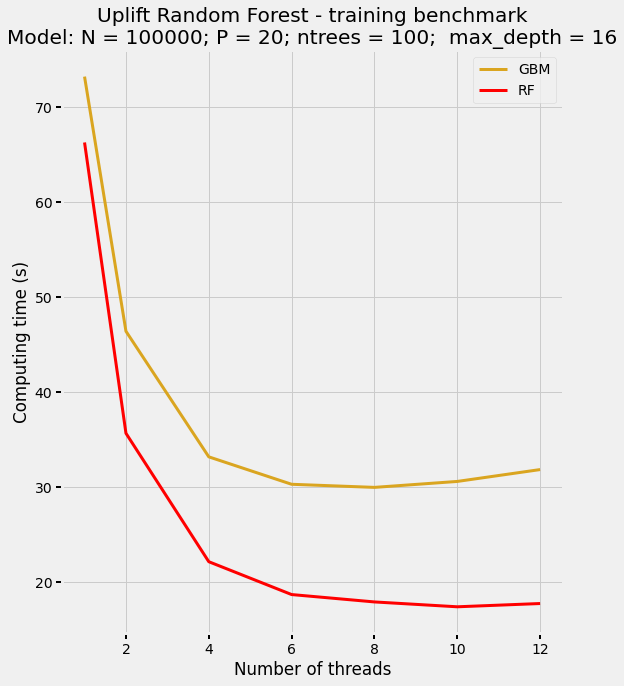

In [22]:
plot_result(gbm_time0, rf_time0)

In [23]:
N = 100000
P = 20
max_depth = 16
nbins=400
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [24]:
gbm_time1, rf_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwavtzvav
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwavtzvav\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwavtzvav\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_9es0d7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 92.81019401550293s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.835299015045166s
H2O session _sid_b8df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcp70yim_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcp70yim_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcp70yim_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_f2hlhu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 92.21406888961792s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.87096643447876s
H2O session _sid_a972 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjdhptkhm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjdhptkhm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjdhptkhm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_6sszxr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 91.87835240364075s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.21556806564331s
H2O session _sid_be9b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_38_egx9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_38_egx9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_38_egx9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_fbs2a4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 94.26996421813965s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.018786668777466s
H2O session _sid_bc37 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu62k3b12
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu62k3b12\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu62k3b12\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_oyemn7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 93.80320930480957s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.925063133239746s
H2O session _sid_bcb4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8uyvlsyn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8uyvlsyn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8uyvlsyn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_7dn6gd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 93.03524398803711s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.89886546134949s
H2O session _sid_9eb7 closed.
Uplift 93.00183880329132s
RF 35.960758129755654s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp71kft8cw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp71kft8cw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp71kft8cw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_b95n2q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 82.83966565132141s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.17743921279907s
H2O session _sid_9f2f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa7q94mxm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa7q94mxm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa7q94mxm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_tuw1lc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 82.80336999893188s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.02898287773132s
H2O session _sid_9926 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyvwj7ne0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyvwj7ne0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyvwj7ne0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_7eum91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 83.07366180419922s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.188477993011475s
H2O session _sid_a6da closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgvwmkmjf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgvwmkmjf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgvwmkmjf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_o2mmfe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 82.86339116096497s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.227657318115234s
H2O session _sid_b871 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgosxnbl6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgosxnbl6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgosxnbl6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_jc1x7k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 82.01617360115051s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.88860630989075s
H2O session _sid_baf3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1tb0q5gc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1tb0q5gc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1tb0q5gc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_dgazml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 83.1264591217041s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.12215971946716s
H2O session _sid_9359 closed.
Uplift 82.78712022304535s
RF 34.10555390516917s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsex2y5_4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsex2y5_4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsex2y5_4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_wsljso
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 77.2042646408081s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.51570701599121s
H2O session _sid_ab02 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiu3edy4p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiu3edy4p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiu3edy4p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_s02l1z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.23435068130493s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.64723348617554s
H2O session _sid_addc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkklknsq2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkklknsq2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkklknsq2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_j5xd6u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.35706686973572s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.70566463470459s
H2O session _sid_8588 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt5gu05ic
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt5gu05ic\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt5gu05ic\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_kgfq0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.19800353050232s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.459670066833496s
H2O session _sid_95e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprpkvrj97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprpkvrj97\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprpkvrj97\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_xpn4x9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 79.46239709854126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.697453260421753s
H2O session _sid_8c31 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb3aw44mc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb3aw44mc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb3aw44mc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_dvziww
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.98766756057739s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.385791540145874s
H2O session _sid_b6cb closed.
Uplift 77.07395839691162s
RF 32.401920000712074s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvs7n_8da
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvs7n_8da\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvs7n_8da\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_6onpi7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.0587842464447s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.58024787902832s
H2O session _sid_bc2a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp6xaspk_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp6xaspk_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp6xaspk_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_vvy9ta
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.42027354240417s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.295933485031128s
H2O session _sid_96bd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpexkjlvvh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpexkjlvvh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpexkjlvvh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_8305tj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.79021716117859s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.5006844997406s
H2O session _sid_92e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5gaum5rs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5gaum5rs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5gaum5rs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_eftt22
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.96586513519287s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.397603034973145s
H2O session _sid_b132 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdq0qaj48
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdq0qaj48\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdq0qaj48\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_dlqyyo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.77906823158264s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.567163944244385s
H2O session _sid_9f88 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp1j_wuq_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp1j_wuq_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp1j_wuq_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_ewn6yw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.12934923171997s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.71880602836609s
H2O session _sid_becd closed.
Uplift 72.52392625808716s
RF 31.51007314523061s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmgmb22lf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmgmb22lf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmgmb22lf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_rra1vz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.01643919944763s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.05356693267822s
H2O session _sid_91f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpglxzm4xx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpglxzm4xx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpglxzm4xx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_063vtk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.6452112197876s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.6237587928772s
H2O session _sid_92f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd0zpd068
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd0zpd068\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd0zpd068\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_1k2ckd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.75418829917908s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.753315687179565s
H2O session _sid_9a78 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdsyd_lhi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdsyd_lhi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdsyd_lhi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_chiwhd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.29876828193665s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.57469153404236s
H2O session _sid_a87c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprz5_8uh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprz5_8uh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprz5_8uh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_d1x7ge
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.65531897544861s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.97168326377869s
H2O session _sid_94a6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7wz_do8w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7wz_do8w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7wz_do8w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_jy2647
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.64194130897522s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.405450105667114s
H2O session _sid_8682 closed.
Uplift 71.00197788079579s
RF 34.73041105270386s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpagcq48tk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpagcq48tk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpagcq48tk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_26acpq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 90.47255396842957s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.047715187072754s
H2O session _sid_b20c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpakn9u2dm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpakn9u2dm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpakn9u2dm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_hcof6p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 91.02667737007141s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.25801658630371s
H2O session _sid_b3d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmsdbcuvp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmsdbcuvp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmsdbcuvp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_1iabei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 91.81346106529236s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.019824266433716s
H2O session _sid_be9d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyphs_s7o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyphs_s7o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyphs_s7o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_2t92nb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 90.76653861999512s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.96463346481323s
H2O session _sid_a50e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpol5o09yx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpol5o09yx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpol5o09yx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_ce3yqo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 90.6493809223175s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.99814224243164s
H2O session _sid_86b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9a5rqgc_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9a5rqgc_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9a5rqgc_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_wgnmuf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 89.50822472572327s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.77365303039551s
H2O session _sid_a67b closed.
Uplift 90.70613944530487s
RF 53.176997462908425s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9g1zqv1v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9g1zqv1v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9g1zqv1v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_kxj95p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 139.75995206832886s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.0172860622406s
H2O session _sid_bf80 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmy1fzxcj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmy1fzxcj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmy1fzxcj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_podtqg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 140.52138948440552s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.87454104423523s
H2O session _sid_84c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ecqjfor
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ecqjfor\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1ecqjfor\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_mbylx4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 139.99951481819153s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.37487816810608s
H2O session _sid_a874 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1x1ul7_r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1x1ul7_r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1x1ul7_r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_pa8508
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 140.1954414844513s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.06552648544312s
H2O session _sid_89cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqjicbk24
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqjicbk24\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqjicbk24\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_z3q7g6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.02784490585327s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.74765515327454s
H2O session _sid_a3e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpms767smv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpms767smv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpms767smv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_xam645
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 140.47486066818237s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.92354202270508s
H2O session _sid_899d closed.
Uplift 139.66316723823547s
RF 99.16723815600078s
12 - Uplift = 93.00183880329132, RF = 35.960758129755654
10 - Uplift = 82.78712022304535, RF = 34.10555390516917
8 - Uplift = 77.07395839691162, RF = 32.401920000712074
6 - Uplift = 72.52392625808716, RF = 31.51007314523061
4 - Uplift = 71.00197788079579, RF = 34.73041105270386
2 - Uplift = 90.70613944530487, RF = 53.176997462908425
1 - Uplift = 139.66316723823547, RF = 99.16723815600078


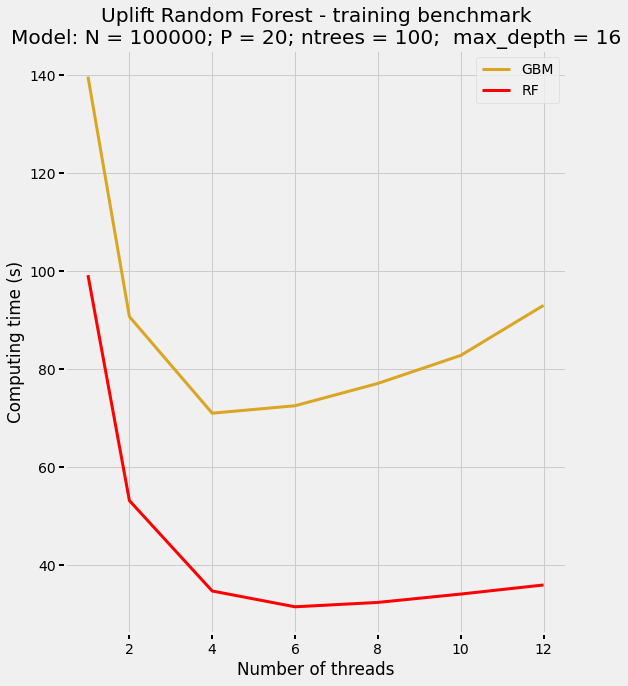

In [25]:
plot_result(gbm_time1, rf_time1)

In [26]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=2000
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [27]:
gbm_time2, rf_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv6_qvpne
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv6_qvpne\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv6_qvpne\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_z1w4rt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.9030830860138s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.53962445259094s
H2O session _sid_bda3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe1xl21_l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe1xl21_l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe1xl21_l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_ont89i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 319.7484083175659s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.29468297958374s
H2O session _sid_8d0a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz_fib2f8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz_fib2f8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz_fib2f8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_nnyuhf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.4324424266815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.79552698135376s
H2O session _sid_81f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpppur4k7_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpppur4k7_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpppur4k7_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_undrdj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.4425046443939s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 109.01958894729614s
H2O session _sid_b9af closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmyd8xcsj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmyd8xcsj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmyd8xcsj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_w0euon
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 322.96462965011597s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.20342659950256s
H2O session _sid_9587 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxpm5ngp6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxpm5ngp6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxpm5ngp6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_dqm7b8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.3475251197815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.66632270812988s
H2O session _sid_91ff closed.
Uplift 318.9730988740921s
RF 107.9198621114095s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr3runiue
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr3runiue\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr3runiue\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_h0j8ng
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 290.89732122421265s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.8343448638916s
H2O session _sid_a298 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphsnspbkr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphsnspbkr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphsnspbkr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_htskmz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.12831473350525s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.0281867980957s
H2O session _sid_a87f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaog4sgji
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaog4sgji\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaog4sgji\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_on1b9l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 289.92364382743835s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.95088982582092s
H2O session _sid_8e56 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfinlemzs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfinlemzs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfinlemzs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_ekvwiu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 290.24032640457153s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.1290876865387s
H2O session _sid_8a36 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmsikyrix
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmsikyrix\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmsikyrix\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_e234le
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.05083417892456s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.5218460559845s
H2O session _sid_a7c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp59kwlip0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp59kwlip0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp59kwlip0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_qwkyw6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 287.8378360271454s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.68187522888184s
H2O session _sid_a397 closed.
Uplift 290.67971273263294s
RF 99.52437174320221s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyph5w5wl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyph5w5wl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyph5w5wl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_9p8tkq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 270.3093829154968s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.65654563903809s
H2O session _sid_ae61 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjwmndfsw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjwmndfsw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjwmndfsw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_cligfa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.2174780368805s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.58643889427185s
H2O session _sid_a4d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsiew_m_8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsiew_m_8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsiew_m_8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_8t3wmh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.6744980812073s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.878488779068s
H2O session _sid_86c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2vtb9q_c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2vtb9q_c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2vtb9q_c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_u8c20s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.30762362480164s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.50999975204468s
H2O session _sid_87fa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp744aqtf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp744aqtf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp744aqtf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_e340jf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 270.9198250770569s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.56974482536316s
H2O session _sid_b76c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1x492rph
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1x492rph\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1x492rph\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_9jg0ch
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.1168329715729s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.43347311019897s
H2O session _sid_a4e0 closed.
Uplift 269.090940117836s
RF 91.43911516666412s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprmfr_co
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprmfr_co\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprmfr_co\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_hus7du
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 246.5835897922516s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.25234627723694s
H2O session _sid_94d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqdl17qic
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqdl17qic\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqdl17qic\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_il7jit
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 248.82100415229797s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.87216639518738s
H2O session _sid_a460 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaxrz5tzz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaxrz5tzz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaxrz5tzz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_qxfvgn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 248.67083191871643s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.44783663749695s
H2O session _sid_8ab8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpffyt113w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpffyt113w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpffyt113w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_7zbrrz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 250.92564725875854s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 88.8245894908905s
H2O session _sid_96c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9b2ht2hx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9b2ht2hx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9b2ht2hx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_j8iroy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 252.1754789352417s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.12526345252991s
H2O session _sid_8317 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk_88f0qr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk_88f0qr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk_88f0qr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_uayzu7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 244.9073143005371s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.97234678268433s
H2O session _sid_8400 closed.
Uplift 248.68064439296722s
RF 86.58242483933766s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp084o0reu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp084o0reu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp084o0reu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_nlhbiv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 225.17488074302673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.09897637367249s
H2O session _sid_80d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf864hz1x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf864hz1x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf864hz1x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_9b8x1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 225.91945624351501s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.58986186981201s
H2O session _sid_a59d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf5hhye5k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf5hhye5k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf5hhye5k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_smgn9w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 224.87597060203552s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.13697791099548s
H2O session _sid_aab0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyuia8qta
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyuia8qta\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyuia8qta\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_487huv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 225.41818523406982s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.26831865310669s
H2O session _sid_b778 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbasxp3j9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbasxp3j9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbasxp3j9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_xh14li
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 232.752037525177s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 88.5157539844513s
H2O session _sid_b728 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppsf1e_a2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppsf1e_a2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppsf1e_a2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_mdojju
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 229.1886146068573s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.46093034744263s
H2O session _sid_a56a closed.
Uplift 227.22152415911356s
RF 86.6784698565801s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9p1t8muc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9p1t8muc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9p1t8muc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_a5eij0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 260.352281332016s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.15311431884766s
H2O session _sid_ad18 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphbwidp9x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphbwidp9x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphbwidp9x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_tiss1y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.4707975387573s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 125.57494926452637s
H2O session _sid_9e73 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy8pynev4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy8pynev4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy8pynev4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_szjzm8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 258.2328243255615s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 120.83372569084167s
H2O session _sid_8ee4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw_2mhag8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw_2mhag8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw_2mhag8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_tsk742
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 265.9352385997772s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 125.7900173664093s
H2O session _sid_add6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm0ex7t6_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm0ex7t6_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm0ex7t6_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_ny94de
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.5662820339203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.85883975028992s
H2O session _sid_bb2b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl_de3gnh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl_de3gnh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl_de3gnh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_3xvbfc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.6044661998749s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.18017268180847s
H2O session _sid_9763 closed.
Uplift 261.5269816716512s
RF 122.56513651212056s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2dhevr43
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2dhevr43\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2dhevr43\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_zyi6ml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 379.90907621383667s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 222.09303879737854s
H2O session _sid_89ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdog3mx2b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdog3mx2b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdog3mx2b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_66pocy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 378.0128393173218s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 222.18853425979614s
H2O session _sid_a8cc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi04fc3cv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi04fc3cv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi04fc3cv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_kyyoon
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 376.6242618560791s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 220.25081038475037s
H2O session _sid_a3d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkpp4boq7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkpp4boq7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkpp4boq7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_yqb111
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 378.9189898967743s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 222.6904890537262s
H2O session _sid_8e4f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3bxl923v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3bxl923v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3bxl923v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_g1j4j5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.7429187297821s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 221.31747174263s
H2O session _sid_ad0c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps102c0px
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps102c0px\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps102c0px\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_5e5mr6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 397.1886739730835s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 230.472838640213s
H2O session _sid_bdb3 closed.
Uplift 381.06612666447955s
RF 223.16886381308237s
12 - Uplift = 318.9730988740921, RF = 107.9198621114095
10 - Uplift = 290.67971273263294, RF = 99.52437174320221
8 - Uplift = 269.090940117836, RF = 91.43911516666412
6 - Uplift = 248.68064439296722, RF = 86.58242483933766
4 - Uplift = 227.22152415911356, RF = 86.6784698565801
2 - Uplift = 261.5269816716512, RF = 122.56513651212056
1 - Uplift = 381.06612666447955, RF = 223.16886381308237


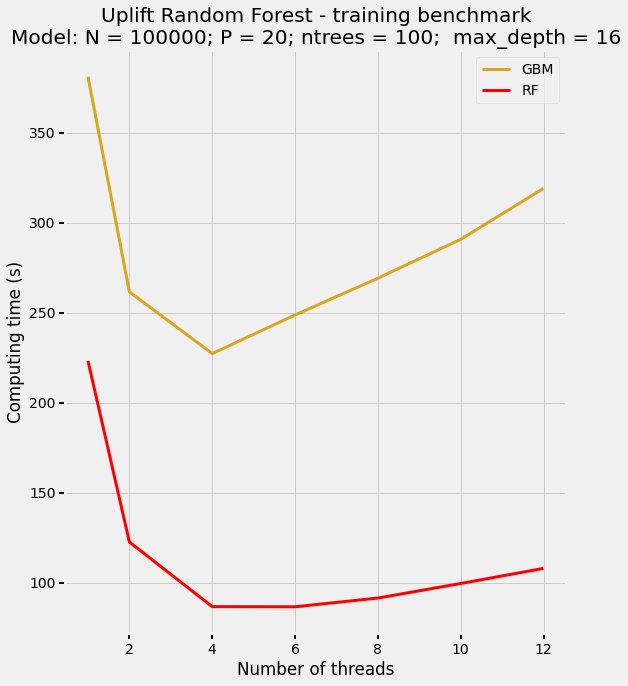

In [28]:
plot_result(gbm_time2, rf_time2)

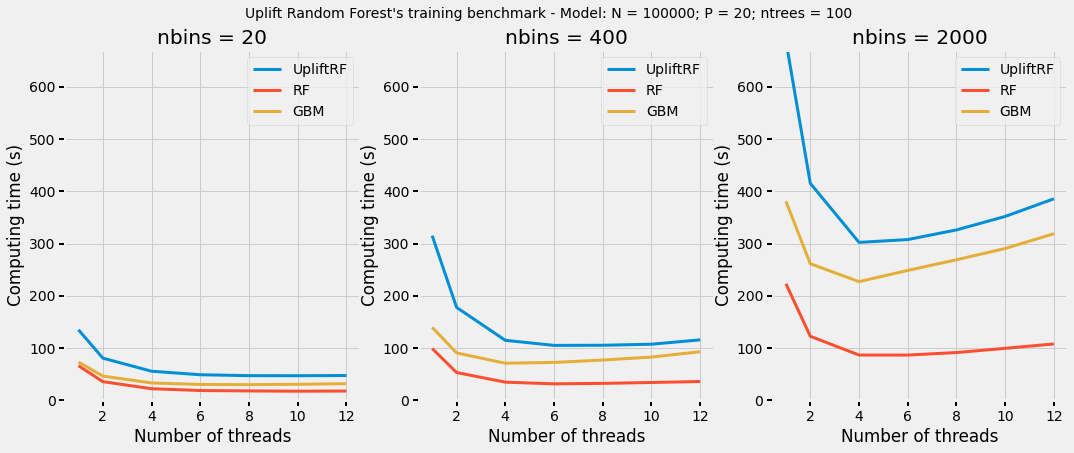

In [29]:
all_predict_uplift = [{12: 47.41590563456217, 10: 47.09019978841146, 8: 47.20285773277283, 6: 48.934909184773765, 4: 55.68334444363912, 2: 80.77636043230693, 1: 135.0319495598475}, {12: 115.73719743887584, 10: 107.39745060602824, 8: 105.37701443831126, 6: 105.14607735474904, 4: 114.84956920146942, 2: 177.93514688809714, 1: 315.1645288467407}, {12: 385.8683665196101, 10: 352.0414063135783, 8: 326.2400721311569, 6: 307.7587921222051, 4: 302.36467655499774, 2: 415.5071925719579, 1: 687.9979410171509}]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)  
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 670)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [30]:
print(all_predict_uplift)

[{12: 47.41590563456217, 10: 47.09019978841146, 8: 47.20285773277283, 6: 48.934909184773765, 4: 55.68334444363912, 2: 80.77636043230693, 1: 135.0319495598475}, {12: 115.73719743887584, 10: 107.39745060602824, 8: 105.37701443831126, 6: 105.14607735474904, 4: 114.84956920146942, 2: 177.93514688809714, 1: 315.1645288467407}, {12: 385.8683665196101, 10: 352.0414063135783, 8: 326.2400721311569, 6: 307.7587921222051, 4: 302.36467655499774, 2: 415.5071925719579, 1: 687.9979410171509}]


In [31]:
print(all_predict_gbm)

[{12: 31.862845540046692, 10: 30.614763418833416, 8: 29.989627877871197, 6: 30.31572099526723, 4: 33.20208215713501, 2: 46.41166512171427, 1: 73.19678485393524}, {12: 93.00183880329132, 10: 82.78712022304535, 8: 77.07395839691162, 6: 72.52392625808716, 4: 71.00197788079579, 2: 90.70613944530487, 1: 139.66316723823547}, {12: 318.9730988740921, 10: 290.67971273263294, 8: 269.090940117836, 6: 248.68064439296722, 4: 227.22152415911356, 2: 261.5269816716512, 1: 381.06612666447955}]


In [32]:
print(all_predict_rf)

[{12: 17.77284888426463, 10: 17.429598371187847, 8: 17.940160473187763, 6: 18.716358304023743, 4: 22.17215351263682, 2: 35.6810447772344, 1: 66.26945110162099}, {12: 35.960758129755654, 10: 34.10555390516917, 8: 32.401920000712074, 6: 31.51007314523061, 4: 34.73041105270386, 2: 53.176997462908425, 1: 99.16723815600078}, {12: 107.9198621114095, 10: 99.52437174320221, 8: 91.43911516666412, 6: 86.58242483933766, 4: 86.6784698565801, 2: 122.56513651212056, 1: 223.16886381308237}]


## Evaluation Stage

In [33]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth+1)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        
    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])

    return eif_means, if_means 

def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [34]:
# Evaluation stage parameters

N = 500
P = 2
N_train = 500
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time18, if_time18 = run_predict_benchmark(X_train, X_test)

NameError: name 'make_blobs' is not defined

In [ ]:
plot_predict(eif_time18, if_time18)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 30
N_train = 500_000
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time10, if_time10 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time10, if_time10)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 5_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time11, if_time11 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time11, if_time11)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 20_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time12, if_time12 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time12, if_time12)

### Real Credit Card Fraud Detection Data

In [ ]:
sample_sizes = []

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = 256
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time14, if_time14 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time14, if_time14)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time15, if_time15 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time15, if_time15)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time16, if_time16 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time16, if_time16)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.10)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time17, if_time17 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time17, if_time17)

In [ ]:
all_predict_eif = [eif_time14, eif_time15, eif_time16]
all_predict_if = [if_time14, if_time15, if_time16]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Extended Isolation Forest's scoring benchmark - Frame to score: N = {N}; P = {P}. Model: N = {N_train}; P = {P}; ntrees = {ntrees}.", fontsize=14)

for eif_time, if_time, i in zip(all_predict_eif, all_predict_if, range(1, len(sample_sizes) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"EIF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in if_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"IF", linewidth=3)    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 40)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"sample_size = {sample_sizes[i - 1]}; max_depth = {math.ceil(math.log(sample_sizes[i - 1], 2))}")

plt.savefig(f"h2o-score-perf_credit{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()